In [1]:
import fitz
from difflib import SequenceMatcher
from typing import List, Dict, Tuple
from tqdm import tqdm
import string
from pprint import pprint
import pandas as pd
import uuid

pdf_path = "./data/Distributed_Systems_4.pdf"

doc = fitz.open(pdf_path)

In [2]:
# to_markdown function
if fitz.pymupdf_version_tuple < (1, 24, 0):
    raise NotImplementedError("PyMuPDF version 1.24.0 or later is needed.")

def to_markdown(doc: fitz.Document, pages: list = None) -> str:
    """Process the document and return the text of its selected pages."""
    if isinstance(doc, str):
        doc = fitz.open(doc)
    SPACES = set(string.whitespace)  # used to check relevance of text pieces
    if not pages:  # use all pages if argument not given
        pages = range(doc.page_count)

    class IdentifyHeaders:
        """Compute data for identifying header text."""

        def __init__(self, doc, pages: list = None, body_limit: float = None):
            """Read all text and make a dictionary of fontsizes.

            Args:
                pages: optional list of pages to consider
                body_limit: consider text with larger font size as some header
            """
            if pages is None:  # use all pages if omitted
                pages = range(doc.page_count)
                
            fontsizes = {}
            for pno in pages:
                page = doc[pno]
                blocks = page.get_text("dict", flags=fitz.TEXTFLAGS_TEXT)["blocks"]
                for span in [  # look at all non-empty horizontal spans
                    s
                    for b in blocks
                    for l in b["lines"]
                    for s in l["spans"]
                    if not SPACES.issuperset(s["text"])
                ]:
                    fontsz = round(span["size"])
                    count = fontsizes.get(fontsz, 0) + len(span["text"].strip())
                    fontsizes[fontsz] = count

            # maps a fontsize to a string of multiple # header tag characters
            self.header_id = {}

            # If not provided, choose the most frequent font size as body text.
            # If no text at all on all pages, just use 12
            if body_limit is None:
                temp = sorted(
                    [(k, v) for k, v in fontsizes.items()],
                    key=lambda i: i[1],
                    reverse=True,
                )
                if temp:
                    body_limit = temp[0][0]
                else:
                    body_limit = 12

            sizes = sorted(
                [f for f in fontsizes.keys() if f > body_limit], reverse=True
            )

            # make the header tag dictionary
            for i, size in enumerate(sizes):
                self.header_id[size] = "#" * (i + 1) + " "

        def get_header_id(self, span, line_spans):
            """Return appropriate markdown header prefix.

            Given a text span from a "dict"/"radict" extraction, determine the
            markdown header prefix string of 0 to many concatenated '#' characters.
            """
            fontsize = round(span["size"])  # compute fontsize
            hdr_id = self.header_id.get(fontsize, "")

            bold = span["flags"] & 16
            standalone = len(line_spans) == 1 and not SPACES.issuperset(span["text"])
            if bold and standalone and not hdr_id:
                # If the span is bold and standalone, consider it as a heading
                if hdr_id == "":
                    smallest_heading = max(self.header_id.values(), default="")
                    hdr_id = "#" * (len(smallest_heading.strip()) + 1) + " "

                
            return hdr_id

    def resolve_links(links, span):
        """Accept a span bbox and return a markdown link string."""
        bbox = fitz.Rect(span["bbox"])  # span bbox
        # a link should overlap at least 70% of the span
        bbox_area = 0.7 * abs(bbox)
        for link in links:
            hot = link["from"]  # the hot area of the link
            if not abs(hot & bbox) >= bbox_area:
                continue  # does not touch the bbox
            text = f'[{span["text"].strip()}]({link["uri"]})'
            return text

    def write_text(page, clip, hdr_prefix):
        """Output the text found inside the given clip.

        This is an alternative for plain text in that it outputs
        text enriched with markdown styling.
        The logic is capable of recognizing headers, body text, code blocks,
        inline code, bold, italic and bold-italic styling.
        There is also some effort for list supported (ordered / unordered) in
        that typical characters are replaced by respective markdown characters.
        """
        out_string = ""
        code = False  # mode indicator: outputting code

        # extract URL type links on page
        links = [l for l in page.get_links() if l["kind"] == 2]

        blocks = page.get_text(
            "dict",
            clip=clip,
            flags=fitz.TEXTFLAGS_TEXT,
            sort=True,
        )["blocks"]

        for block in blocks:  # iterate textblocks
            previous_y = 0
            for line in block["lines"]:  # iterate lines in block
                if line["dir"][1] != 0:  # only consider horizontal lines
                    continue
                spans = [s for s in line["spans"]]

                this_y = line["bbox"][3]  # current bottom coord

                # check for still being on same line
                same_line = abs(this_y - previous_y) <= 3 and previous_y > 0

                if same_line and out_string.endswith("\n"):
                    out_string = out_string[:-1]

                # are all spans in line in a mono-spaced font?
                all_mono = all([s["flags"] & 8 for s in spans])

                # compute text of the line
                text = "".join([s["text"] for s in spans])
                if not same_line:
                    previous_y = this_y
                    if not out_string.endswith("\n"):
                        out_string += "\n"

                if all_mono:
                    # compute approx. distance from left - assuming a width
                    # of 0.5*fontsize.
                    delta = int(
                        (spans[0]["bbox"][0] - block["bbox"][0])
                        / (spans[0]["size"] * 0.5)
                    )
                    if not code:  # if not already in code output  mode:
                        out_string += "```"  # switch on "code" mode
                        code = True
                    if not same_line:  # new code line with left indentation
                        out_string += "\n" + " " * delta + text + " "
                        previous_y = this_y
                    else:  # same line, simply append
                        out_string += text + " "
                    continue  # done with this line

                for i, s in enumerate(spans):  # iterate spans of the line
                    # this line is not all-mono, so switch off "code" mode
                    if code:  # still in code output mode?
                        out_string += "```\n"  # switch of code mode
                        code = False
                    # decode font properties
                    mono = s["flags"] & 8
                    bold = s["flags"] & 16
                    italic = s["flags"] & 2

                    if mono:
                        # this is text in some monospaced font
                        out_string += f"`{s['text'].strip()}` "
                    else:  # not a mono text
                        # for first span, get header prefix string if present
                        if i == 0:
                            hdr_string = hdr_prefix.get_header_id(s, line["spans"])
                        else:
                            hdr_string = ""
                        prefix = ""
                        suffix = ""
                        if hdr_string == "":
                            if bold:
                                prefix = "**"
                                suffix += "**"
                            if italic:
                                prefix += "_"
                                suffix = "_" + suffix

                        ltext = resolve_links(links, s)
                        if ltext:
                            text = f"{hdr_string}{prefix}{ltext}{suffix} "
                        else:
                            text = f"{hdr_string}{prefix}{s['text'].strip()}{suffix} "
                        text = (
                            text.replace("<", "&lt;")
                            .replace(">", "&gt;")
                            .replace(chr(0xF0B7), "-")
                            .replace(chr(0xB7), "-")
                            .replace(chr(8226), "-")
                            .replace(chr(9679), "-")
                        )
                        out_string += text
                previous_y = this_y
                if not code:
                    out_string += "\n"
            out_string += "\n"
        if code:
            out_string += "```\n"  # switch of code mode
            code = False
        return out_string.replace(" \n", "\n")

    hdr_prefix = IdentifyHeaders(doc, pages=pages)
    md_string = ""
    md_pages = []  # list to hold text and metadata
    for pno in tqdm(pages):
        page = doc[pno]
        # 1. first locate all tables on page
        tabs = page.find_tables()
        md_page = ""  # string to hold markdown for this page

        # 2. make a list of table boundary boxes, sort by top-left corner.
        # Must include the header bbox, which may be external.
        tab_rects = sorted(
            [
                (fitz.Rect(t.bbox) | fitz.Rect(t.header.bbox), i)
                for i, t in enumerate(tabs.tables)
            ],
            key=lambda r: (r[0].y0, r[0].x0),
        )

        # 3. final list of all text and table rectangles
        text_rects = []
        # compute rectangles outside tables and fill final rect list
        for i, (r, idx) in enumerate(tab_rects):
            if i == 0:  # compute rect above all tables
                tr = page.rect
                tr.y1 = r.y0
                if not tr.is_empty:
                    text_rects.append(("text", tr, 0))
                text_rects.append(("table", r, idx))
                continue
            # read previous rectangle in final list: always a table!
            _, r0, idx0 = text_rects[-1]

            # check if a non-empty text rect is fitting in between tables
            tr = page.rect
            tr.y0 = r0.y1
            tr.y1 = r.y0
            if not tr.is_empty:  # empty if two tables overlap vertically!
                text_rects.append(("text", tr, 0))

            text_rects.append(("table", r, idx))

            # there may also be text below all tables
            if i == len(tab_rects) - 1:
                tr = page.rect
                tr.y0 = r.y1
                if not tr.is_empty:
                    text_rects.append(("text", tr, 0))

        if not text_rects:  # this will happen for table-free pages
            text_rects.append(("text", page.rect, 0))
        else:
            rtype, r, idx = text_rects[-1]
            if rtype == "table":
                tr = page.rect
                tr.y0 = r.y1
                if not tr.is_empty:
                    text_rects.append(("text", tr, 0))

        # we have all rectangles and can start outputting their contents
        for rtype, r, idx in text_rects:
            if rtype == "text":  # a text rectangle
                text = write_text(page, r, hdr_prefix)# write MD content
                text += "\n"
                md_page += text  
                md_string += text  # write MD content
            else:  # a table rect
                md_tab = tabs[idx].to_markdown(clean=False)
                
                md_page += md_tab
                md_string += md_tab
            
        md_string += "\n-----\n\n"
        
        # Split the page into blocks for further processing
        blocks = md_page.split("\n\n")
        for i, block in enumerate(blocks):
            text = block.replace("-\n", "")
            text = block.replace("-**\n**", "")
            
             
            text = text.replace("\n", " ").strip()
            
            if text == "":
                blocks.pop(i)
            else:
                blocks[i] = text
        md_pages.append({
            "document": md_page, 
            "page_number": pno+1, 
            "blocks": blocks
            })  
    return md_pages



In [3]:
# remove potential headers and footers

def similar(a: str, b: str, matcher=SequenceMatcher(None, '', '')) -> float:
    matcher.set_seqs(a, b)
    return matcher.ratio()


def identify_potential_headers_or_footers(blocks: List[str], threshold: float = 0.8) -> List[Tuple[int, List[int]]]:
    potential_blocks = []
    for i, block in tqdm(enumerate(blocks)):
        similarities = [similar(block, other_block) for other_block in blocks]
        similar_indices = [j for j, sim in enumerate(similarities) if sim > threshold]
        if len(similar_indices) > 1:
            potential_blocks.append((i, similar_indices))
    return potential_blocks

def has_header_or_footer(num_pages: int, potential_blocks: List[Tuple[int, List[int]]]) -> List[bool]:
    block_indices = {index for index, _ in potential_blocks}
    return [i in block_indices for i in range(num_pages)]

def remove_headers_or_footers(md_p: List[Dict], header: bool, has_block: List[bool]) -> List[Dict]:
    for page, has_header_or_footer in zip(md_p, has_block):
        if has_header_or_footer:
            page["blocks"] = page["blocks"][1:] if header else page["blocks"][:-1]
    return md_p

def remove_headers_and_footers(md_p: List[Dict]) -> List[Dict]:
    for header in [True, False]:
        print("Removing potential headers") if header else print("Removing potential footers")
        blocks = [page["blocks"][0 if header else -1] for page in md_p if page["blocks"]]
        potential_blocks = identify_potential_headers_or_footers(blocks)
        has_block = has_header_or_footer(len(md_p), potential_blocks)
        md_p = remove_headers_or_footers(md_p, header, has_block)
    return md_p

def find_entities_by_page(paragraphs: List[Dict], page_number: int) -> List[Dict]:
    return [entity for entity in paragraphs if entity.get('pagenumber') == page_number]


#### Getting Cleaned Pages
1. Get markdown text
2. Remove headers and footers.
3. Store whole pages in a db with a uid for traceable chunking.
4. Split pages into blocks 
    
    4.1 TODO: Store them with a unique ids and the parent page ID
5. Split block into sentences 
    
    5.1 TODO: Store sentences with a ID and its parent block id.

In [4]:
# getting markdown pages
start_page = 16
end_page = 632
doc = fitz.open(pdf_path)  # open input file
pages = range(start_page, end_page) # get page range

md_pages = to_markdown(doc, pages=pages) # get markdown paragraphs as list of pages
md_pages = remove_headers_and_footers(md_pages) # remove potential headers and footers from pages

100%|██████████| 616/616 [00:17<00:00, 35.90it/s]


Removing potential headers


613it [00:09, 64.90it/s]


Removing potential footers


613it [00:06, 88.51it/s]


In [5]:
# create a dataframe with the pages, blocks and sentences
import spacy
import re

def create_blocks_df(md_pages_df):
    blocks = []
    for _, row in md_pages_df.iterrows():
        for block in row['blocks']:
            blocks.append({
                "id": uuid.uuid4(),
                "order_id": len(blocks), 
                "text": block, 
                "page_number": row["page_number"], 
                "page_id": row["id"]
            })

    blocks_df = pd.DataFrame(blocks)
    return blocks_df

def create_sentences_df(blocks_df):
    nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner"])
    nlp.add_pipe("sentencizer")
    sentences = []
    for _, row in blocks_df.iterrows():
        doc = nlp(row['text'])
        for sent in doc.sents:
            sentences.append({
                "id": uuid.uuid4(),
                "order_id": len(sentences),
                "text": sent.text, 
                "block_id": row["id"]})

    sentences_df = pd.DataFrame(sentences)
    return sentences_df

def assign_chapters(df):
    chapters = []
    current_chapter = "None"
    parent_chapter = "None"
    for idx, row in df.iterrows():
        chapter_level = 0
        if row['text'].startswith('#'):
            chapter_level = row['text'].split(" ")[0].count('#')
            if not chapters or chapters[-1][1] < chapter_level:
                chapters.append((row['text'], chapter_level))
            else:
                while(chapters and chapters[-1][1] >= chapter_level):
                    chapters.pop()
                chapters.append((row['text'], chapter_level))
            current_chapter = chapters[-1][0]
            if len(chapters) > 1:
                parent_chapter = chapters[-2][0]
                
        df.at[idx, 'chapter'] = current_chapter.replace('#', '') 
        df.at[idx, 'parent_chapter'] = parent_chapter.replace('#', '')


def determine_block_type(text):
    if re.search(r'^\s*\d+\.\s', text):
        return 'numbered_list'
    elif re.search(r'^\s*[-]\s', text):
        return 'bullet_list'
    elif re.search(r'^\s*[|]\s', text):
        return 'table'
    elif re.search(r'^\s*[>]\s', text):
        return 'quote'
    elif re.search(r'^\s*#+\s', text):
        return 'header'
    elif re.search(r'^\s*\w+\s*=', text) or re.search(r'^\s*\w+\s*:=', text):
        return 'code'
    elif re.search(r'^\s*class\s+\w+', text) or re.search(r'^\s*def\s+\w+', text):
        return 'code'
    elif re.search(r'^\s*if\s+', text) or re.search(r'^\s*for\s+', text) or re.search(r'^\s*while\s+', text):
        return 'code'
    elif re.search(r'^\s*import\s+', text) or re.search(r'^\s*from\s+', text):
        return 'code'
    else:
        return 'n/a'


pages_df = pd.DataFrame(md_pages)
pages_df = pages_df.rename(columns={"document": "text"})

pages_df['order_id'] = range(1, len(md_pages) + 1)
pages_df['id'] = [uuid.uuid4() for _ in range(len(md_pages))]

blocks_df = create_blocks_df(pages_df)
pages_df.drop(columns=['blocks'], inplace=True)
sentences_df = create_sentences_df(blocks_df)

assign_chapters(sentences_df)

chapters_df = sentences_df.groupby('block_id')[['chapter', 'parent_chapter']].first().reset_index()
blocks_df = blocks_df.merge(chapters_df, left_on='id', right_on='block_id', how='left')
blocks_df = blocks_df.drop(columns=['block_id'])

chapters_df = blocks_df.groupby('page_id')[['chapter', 'parent_chapter']].first().reset_index()
pages_df = pages_df.merge(chapters_df, left_on='id', right_on='page_id', how='left')
pages_df = pages_df.drop(columns=['page_id'])

blocks_df = blocks_df[~blocks_df["text"].str.startswith("#")]
sentences_df = sentences_df[~sentences_df["text"].str.startswith("#")]

blocks_df['block_type'] = blocks_df['text'].apply(determine_block_type)

# blocks_df['num_sentences'] = blocks_df['text'].apply(lambda x: x.count('.') + x.count('!') + x.count('?'))
# blocks_df['num_words'] = blocks_df['text'].apply(lambda x: len(x.split()))
# blocks_df['num_chars'] = blocks_df['text'].apply(len)
# blocks_df['token_count'] = blocks_df['num_chars'].apply(lambda x: round(x/4))


/home/buddy/Study-Buddy/env/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


##### DATABASE SETUP

TODO: 
1. Transfer dataframes to database
2. Create embeddings and store in seperate vectordb 


In [ ]:
# transfer df to db

In [14]:
blocks_df['block_type'] = blocks_df['text'].apply(determine_block_type)

In [19]:
blocks_df['num_sentences'] = blocks_df[blocks_df["block_type"] == "n/a"]['text'].apply(lambda x: x.count('.') + x.count('!') + x.count('?'))

blocks_df[blocks_df["num_sentences"] < 1][100:300]


,id,order_id,text,page_number,page_id,chapter,parent_chapter,num_sentences,block_type
522,6d58a42c-5250-4154-b0b3-7a58139100e8,522,Application,97,4b6e25ee-7460-40b6-adee-4368ef4bd7c5,2.3.2 Multitiered Architectures,2.3 Layered-system architectures,0.0,n/a
523,b81dbb92-3681-4201-9de6-ad5de56d136e,523,Database,97,4b6e25ee-7460-40b6-adee-4368ef4bd7c5,2.3.2 Multitiered Architectures,2.3 Layered-system architectures,0.0,n/a
524,44ed1f42-95dd-4ff8-8e19-55cc1072685b,524,User interface,97,4b6e25ee-7460-40b6-adee-4368ef4bd7c5,2.3.2 Multitiered Architectures,2.3 Layered-system architectures,0.0,n/a
525,45586abf-8aae-4014-9053-3bcd84010da2,525,n o i t a c i l p p A n o i t a c i l p p A n ...,97,4b6e25ee-7460-40b6-adee-4368ef4bd7c5,2.3.2 Multitiered Architectures,2.3 Layered-system architectures,0.0,n/a
526,44489123-a150-4b86-953e-f7d6d8d59671,526,Database Database Database Database Database,97,4b6e25ee-7460-40b6-adee-4368ef4bd7c5,2.3.2 Multitiered Architectures,2.3 Layered-system architectures,0.0,n/a
...,...,...,...,...,...,...,...,...,...
1224,ec02f3a9-cb52-4ba3-b1b0-5e64330ac9b2,1224,18 **if** APPEND == msgrpc[0]: # check what is...,214,79eb8b4f-71c8-45de-8e5c-46c65780b6e2,4.2.2 Parameter passing,4.2 Remote procedure call,0.0,n/a
1233,8eb539ed-ed2b-4319-99b5-5c6c0a611a8c,1233,Machine A Machine B,216,9d1d1171-8c84-4c00-b9d5-4f31cf9ab1bb,4.2.2 Parameter passing,4.2 Remote procedure call,0.0,n/a
1234,2a608dca-1e4a-4139-9621-ddeb54226af7,1234,Local object O1,216,9d1d1171-8c84-4c00-b9d5-4f31cf9ab1bb,4.2.2 Parameter passing,4.2 Remote procedure call,0.0,n/a
1235,3cb7e283-5ce8-4e20-b1ab-d755d7ccad09,1235,Remote object O2 Local reference L1,216,9d1d1171-8c84-4c00-b9d5-4f31cf9ab1bb,4.2.2 Parameter passing,4.2 Remote procedure call,0.0,n/a


In [13]:
import re

def determine_block_type(text):
    if re.search(r'^\s*\d+\.\s', text):
        return 'numbered_list'
    elif re.search(r'^\s*[-]\s', text):
        return 'bullet_list'
    elif re.search(r'^\s*[|]', text):
        return 'table'
    elif re.search(r'^\s*[>]\s', text):
        return 'quote'
    elif re.search(r'^\s*#+\s', text):
        return 'header'
    elif re.search(r'^\s*\w+\s*=', text) or re.search(r'^\s*\w+\s*:=', text):
        return 'code'
    elif re.search(r'^\s*class\s+\w+', text) or re.search(r'^\s*def\s+\w+', text):
        return 'code'
    elif re.search(r'^\s*if\s+', text) or re.search(r'^\s*for\s+', text) or re.search(r'^\s*while\s+', text):
        return 'code'
    elif re.search(r'^\s*import\s+', text) or re.search(r'^\s*from\s+', text):
        return 'code'
    else:
        return 'n/a'

In [170]:
blocks_df['block_type'] = blocks_df['text'].apply(determine_block_type)

In [171]:
blocks_df[blocks_df["block_type"] == "code"].describe().round(2)

,order_id,page_number,num_sentences,num_words,num_chars,token_count,is_small_block,distance_to_next_small_block
count,8.00,8.00,8.00,8.00,8.00,8.00,8.00,1.0
mean,2366.88,387.38,9.25,171.38,926.75,231.75,0.12,4.0
std,1303.14,206.26,9.90,196.45,1092.52,273.20,0.35,NaN
min,284.00,62.00,1.00,3.00,39.00,10.00,0.00,4.0
25%,1999.75,320.25,2.75,42.25,215.00,54.00,0.00,4.0
50%,2733.00,440.50,5.50,98.50,536.50,134.00,0.00,4.0
75%,3157.00,515.00,11.50,234.25,1203.00,300.50,0.00,4.0
max,3750.00,619.00,29.00,585.00,3302.00,826.00,1.00,4.0


In [172]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Create a new column for small blocks
blocks_df['is_small_block'] = (blocks_df['num_sentences'] < 2).astype(int)

# Create a new column for block type (assuming you have defined a function to determine block type)
blocks_df['block_type'] = blocks_df['text'].apply(determine_block_type)

# Calculate the distance to the next small block
blocks_df['distance_to_next_small_block'] = (
    blocks_df[blocks_df['is_small_block'] == 1]['order_id'].diff().fillna(0)
)

# Perform clustering on small blocks
small_blocks = blocks_df[blocks_df['is_small_block'] == 1]
X = small_blocks[['order_id', 'distance_to_next_small_block']].values
X_scaled = StandardScaler().fit_transform(X)

clustering = DBSCAN(eps=5, min_samples=2).fit(X_scaled)
small_blocks['cluster'] = clustering.labels_

# Merge small blocks within the same cluster
merged_blocks = small_blocks.groupby(['cluster', 'block_type'])['text'].apply(' '.join).reset_index()

/tmp/ipykernel_2326467/3025141390.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_blocks['cluster'] = clustering.labels_


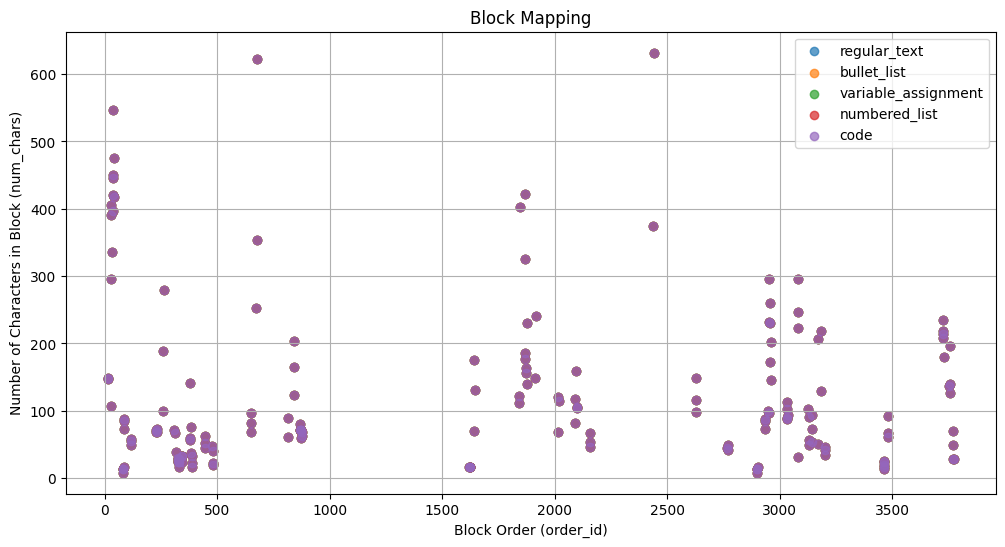

In [173]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(12, 6))
colors = ['red', 'blue', 'green', 'purple', 'yellow', 'cyan']  # Assign colors to different block types
block_types = blocks_df['block_type'].unique()

for i, block_type in enumerate(block_types):
    block_data = blocks_df[blocks_df['block_type'] == "bullet_list"]
#    plt.scatter(block_data['order_id'], block_data['num_chars'], label=block_type, color=colors[i], alpha=0.7)
    plt.scatter(block_data['order_id'], block_data['num_chars'], label=block_type, alpha=0.7)

plt.xlabel('Block Order (order_id)')
plt.ylabel('Number of Characters in Block (num_chars)')
plt.title('Block Mapping')
plt.legend()
plt.grid(True)
plt.show()

In [138]:
blocks_df.describe().round(2)

,order_id,page_number,num_sentences,num_words,num_chars,token_count,small_block_density,block_length,kmeans_cluster,dbscan_cluster
count,3447.00,3447.00,3447.00,3447.00,3447.00,3447.00,3447.00,3447.00,3447.00,3447.0
mean,1936.68,317.11,4.19,73.07,429.08,107.27,0.30,429.08,0.49,0.0
std,1108.86,175.36,6.69,105.77,624.21,156.06,0.26,624.21,0.50,0.0
min,2.00,18.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.0
25%,981.50,174.00,0.00,6.00,39.00,10.00,0.00,39.00,0.00,0.0
50%,1932.00,304.00,2.00,20.00,116.00,29.00,0.25,116.00,0.00,0.0
75%,2903.50,480.00,6.00,103.00,602.50,150.50,0.53,602.50,1.00,0.0
max,3862.00,632.00,198.00,653.00,3591.00,898.00,1.00,3591.00,1.00,0.0


In [137]:
prev_cluster = None
current_block = ""
merged_blocks = []

for _, row in blocks_df.iterrows():
    if row['kmeans_cluster'] == prev_cluster:
        print(row['order_id'])
        print(row['text'])
    else:
        if current_block:
            print("merged_blocks.append(current_block):", current_block)
        print("current_block = row[text]:", row['text'])
        current_block = row['text']
        print("prev_cluster = row[kmeans_cluster]:", row['kmeans_cluster'])
        prev_cluster = row['kmeans_cluster']


current_block = row[text]: The pace at which computer systems change was, is, and continues to be overwhelming. From 1945, when the modern computer era began, until about 1985, computers were large and expensive. Moreover, lacking a way to connect them, these computers operated independently of one another.
prev_cluster = row[kmeans_cluster]: 0
3
Starting in the mid-1980s, however, two advances in technology began to change that situation. The first was the development of powerful microproces- sors. Initially, these were 8-bit machines, but soon 16-, 32-, and 64-bit CPUs became common. With powerful multicore CPUs, we now are again facing the challenge of adapting and developing programs to exploit parallelism. In any case, the current generation of machines have the computing power of the mainframes deployed 30 or 40 years ago, but for 1/1000th of the price or less.
4
The second development was the invention of high-speed computer net- works. **Local-area networks** or **LANs** allow 

In [46]:
sentences_df.head()
blocks_df.head()
pages_df.head()
blocks_df[100:200]

,id,order_id,text,page_number,page_id,chapter,parent_chapter
123,4bc62a2d-4675-44e0-a1c3-f915df56513d,123,Size scalability problems for centralized serv...,41,c34b22b2-6d98-4469-bef4-9b5e72b3be88,Size scalability When a system needs to scale...,1.2.6 Scalability
124,e2d3f224-d015-490a-a102-e445eee1425f,124,"Often, we may assume that the queue has an inf...",42,c503311c-02cc-4798-9b05-912220dc0816,Size scalability When a system needs to scale...,1.2.6 Scalability
125,a9286b56-626b-4a8a-8796-1b5342942a2a,125,_p_ _k_ =   1 _−_ _λ_,42,c503311c-02cc-4798-9b05-912220dc0816,Size scalability When a system needs to scale...,1.2.6 Scalability
126,1375b15b-1d49-4589-b0a4-d438ad43b685,126,_µ_   _λ_,42,c503311c-02cc-4798-9b05-912220dc0816,Size scalability When a system needs to scale...,1.2.6 Scalability
127,15cc26fe-ed8e-4635-8161-a65000ce998b,127,_µ_  _k_,42,c503311c-02cc-4798-9b05-912220dc0816,Size scalability When a system needs to scale...,1.2.6 Scalability
...,...,...,...,...,...,...,...
231,b0b0f252-98c8-45cc-b95e-12ef2f339528,231,- **Isolated** : Concurrent transactions do no...,55,75912199-94b6-4e75-9487-cc093774ac76,Distributed transaction processing,1.3.2 Distributed information systems
232,be8018e8-69c8-4240-b58a-1bee79ef3e71,232,"- **Durable** : Once a transaction commits, th...",55,75912199-94b6-4e75-9487-cc093774ac76,Distributed transaction processing,1.3.2 Distributed information systems
233,23571c22-8052-449a-9e8d-65d35d697f57,233,"In distributed systems, transactions are often...",55,75912199-94b6-4e75-9487-cc093774ac76,Distributed transaction processing,1.3.2 Distributed information systems
234,026c1038-723e-421e-aceb-749982fac942,234,**Figure 1.12:** A nested transaction.,55,75912199-94b6-4e75-9487-cc093774ac76,Distributed transaction processing,1.3.2 Distributed information systems


In [124]:
blocks_df.dtypes, sentences_df.dtypes
blocks_df.describe().round(2)
aaa = blocks_df[blocks_df['text'].str.startswith('-')]
asd = blocks_df[blocks_df['text'].str.match(r"^\d+\.")]
asd

,id,order_id,text,page_number,page_id,chapter,parent_chapter,num_sentences,num_words,num_chars,token_count
274,300b8bb4-5431-4fd7-990d-08b66f99a257,274,"1. ( **Distribution** ) Devices are networked,...",60,5023978c-7cb8-4734-90d3-daad8efe6814,Ubiquitous computing systems,1.3.3 Pervasive systems,1,12,90,22
275,3a91f367-5f2c-49a6-a051-03f0fc2d7501,275,2. ( **Interaction** ) Interaction between use...,60,5023978c-7cb8-4734-90d3-daad8efe6814,Ubiquitous computing systems,1.3.3 Pervasive systems,1,12,82,20
276,2448cdbc-6985-4053-93a5-ed62e2ea2baf,276,3. ( **Context awareness** ) The system is awa...,60,5023978c-7cb8-4734-90d3-daad8efe6814,Ubiquitous computing systems,1.3.3 Pervasive systems,1,16,92,23
277,bd80db5a-4ad4-4af7-9467-822f7089023b,277,4. ( **Autonomy** ) Devices operate autonomous...,60,5023978c-7cb8-4734-90d3-daad8efe6814,Ubiquitous computing systems,1.3.3 Pervasive systems,1,15,109,27
278,90033743-ee40-4396-8a19-69c0c80dd73e,278,5. ( **Intelligence** ) The system as a whole ...,60,5023978c-7cb8-4734-90d3-daad8efe6814,Ubiquitous computing systems,1.3.3 Pervasive systems,1,20,107,27
...,...,...,...,...,...,...,...,...,...,...,...
3710,6c0271d2-4fc5-45a8-8038-d7faaceced8b,3710,4. Attribute-based access control,611,9b280a75-b774-4af6-9d23-562993920825,Access control policies,9.5.1 General issues in access control,1,4,33,8
3776,afa97e85-0bc5-4c4f-829f-c310049a119c,3776,1. **Proof of monotonicity** : A storage opera...,623,7353faf5-b3f9-44f3-ba10-237218e4ea7b,Decentralized storage,9.5.4 Decentralized authorization: an example,2,14,85,21
3777,483f581b-cecc-47ca-871f-fcf5cf798930,3777,2. **Proof of inclusion** : When an object is ...,623,7353faf5-b3f9-44f3-ba10-237218e4ea7b,Decentralized storage,9.5.4 Decentralized authorization: an example,2,17,91,23
3778,c9b3492a-b4ee-439f-a67f-3f3a99873d02,3778,3. **Proof of nonexistence** : When an object ...,623,7353faf5-b3f9-44f3-ba10-237218e4ea7b,Decentralized storage,9.5.4 Decentralized authorization: an example,2,16,90,22


In [37]:
df = sentences_df.merge(blocks_df[['id', 'chapter', 'parent_chapter']], left_on='block_id', right_on='id', how='left')

KeyError: "['chapter', 'parent_chapter'] not in index"

## All good above.

### Block chunking

In [69]:
df_f = df[(df["block"].str.startswith(("#", "-")) | df["block"].str.match(r"^\d+\.")) | (df["num_chars"] >= 10 )]

In [67]:
df_f = df_f.rename(columns={"pagenumber": "page"})
df_f = df_f[~df_f["block"].str.startswith("#")]

df_f = df_f[(df_f["num_chars"] >= 15 )]
df_f = df_f[(df_f["block"].str.startswith(("-")) | (df_f["num_chars"] >= 20 ))]
df_f = df_f[(df_f["block"].str.startswith(("**")) | df_f["block"].str.match(r"^\d+\.")) | (df_f["token_count"] >= 30 )]



/tmp/ipykernel_3740717/539341223.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f['heading'] = df_f['heading'].str.replace('#', '')
/tmp/ipykernel_3740717/539341223.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f['parent_heading'] = df_f['parent_heading'].str.replace('#', '')


### Sentence chunking

In [24]:
#df_f = df[(df["block"].str.startswith(("#", "-", "**")) | df["block"].str.match(r"^\d+\.")) | (df["num_words"] >= 20)]
df_f = df[(df["block"].str.startswith(("#", "-")) | df["block"].str.match(r"^\d+\.")) | (df["num_chars"] >= 10 )]

df_sentence = df.explode("sentences")
df_sentence = df_sentence.rename(columns={"sentences": "sentence"})
df_sentence = df_sentence.rename(columns={"pagenumber": "page"})
df_sentence = df_sentence[["id", "page", "sentence"]]
df_sentence['num_words'] = df_sentence['sentence'].str.split().str.len() # df_sentence['num_words'] = df_sentence['sentence'].apply(lambda x: len(x.split()))
df_sentence['num_chars'] = df_sentence['sentence'].str.len() # df_sentence['num_chars'] = df_sentence['sentence'].apply(len)
df_sentence['token_count'] = (df_sentence['num_chars']/4).round() # df_sentence['token_count'] = df_sentence['num_chars'].apply(lambda x: round(x/4))
df_sentence['heading'] = None  # create a new column for headings
current_heading = None  # variable to hold the current heading

for idx, row in df_sentence.iterrows():
    if row['sentence'].startswith('#'):
        current_heading = row['sentence']  # update the current heading
    df_sentence.at[idx, 'heading'] = current_heading  # assign the current heading

df_sentence['heading'] = df_sentence['heading'].str.replace('#', '')

df_sentence = df_sentence[~df_sentence["sentence"].str.startswith("#")]

df_sentence = df_sentence[(df_sentence["num_chars"] >= 15 )]
df_sentence = df_sentence[(df_sentence["sentence"].str.startswith(("-")) | (df_sentence["num_chars"] >= 20 ))]
df_sentence = df_sentence[(df_sentence["sentence"].str.startswith(("**")) | df_sentence["sentence"].str.match(r"^\d+\.")) | (df_sentence["num_chars"] >= 30 )]


In [31]:
max_sentences = 5
df_chunk = df_sentence[["id", "page", "sentence", "heading"]]


In [33]:
df_chunk['group_id'] = (df_chunk['heading'].ne(df_chunk['heading'].shift()) | df_chunk['page'].ne(df_chunk['page'].shift())).cumsum()
def chunk_sentences(group):
    return group['sentence'].tolist()
df_chunk['chunked_sentences'] = df_chunk.groupby('group_id').apply(chunk_sentences)
df_chunk = df_chunk[df_chunk['chunked_sentences'].str.len() > 0]
df_chunk.reset_index(drop=True, inplace=True)

/tmp/ipykernel_3740717/3353215871.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chunk['group_id'] = (df_chunk['heading'].ne(df_chunk['heading'].shift()) | df_chunk['page'].ne(df_chunk['page'].shift())).cumsum()
/tmp/ipykernel_3740717/3353215871.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_chunk['chunked_sentences'] = df_chunk.groupby('group_id').apply(chunk_sentences)
/tmp/ipykernel_3740717/3353215871.py:4: SettingWithCopyWarning: 
A valu

In [34]:
df_chunk = df_chunk.groupby('group_id').agg({
    'heading': 'first',
    'page': 'first',
    'chunked_sentences': 'sum'
})

# Reset the index
df_chunk.reset_index(drop=True, inplace=True)

In [9]:
df_sentence['structure_type'] = None  # create a new column for headings

df_sentence.describe().round(2)

,id,page,num_words,num_chars,token_count
count,14595.00,14595.00,14595.00,14595.00,14595.00
mean,2438.20,357.85,19.05,111.46,27.87
std,1299.06,198.11,9.70,54.64,13.66
min,7.00,5.00,1.00,22.00,6.00
25%,1270.00,188.00,12.00,70.00,18.00
50%,2536.00,362.00,18.00,103.00,26.00
75%,3494.00,530.00,24.00,143.00,36.00
max,5002.00,685.00,180.00,906.00,226.00


In [51]:
len(df), len(df[df["block"].str.startswith("#")]), len(df[~df["block"].str.startswith(("#", "**"))])

(3861, 217, 3020)

In [78]:
df_f = df[(df["block"].str.startswith(("#", "-", "**")) | df["block"].str.match(r"^\d+\.")) | (df["num_words"] >= 20)]

In [70]:
df.describe().round(2)

,id,page,char_count,word_count,sentence_count,token_count
count,686.00,686.00,686.00,686.00,686.00,686.00
mean,342.50,343.50,2592.11,428.92,30.45,648.03
std,198.18,198.18,712.89,132.26,64.93,178.22
min,0.00,1.00,0.00,0.00,1.00,0.00
25%,171.25,172.25,2285.75,367.25,18.00,571.44
50%,342.50,343.50,2782.50,452.00,23.00,695.62
75%,513.75,514.75,3093.25,503.00,26.00,773.31
max,685.00,686.00,3724.00,1033.00,819.00,931.00


In [25]:
df_sentence.dtypes

id               int64
page             int64
sentence        object
num_words        int64
num_chars        int64
token_count    float64
heading         object
dtype: object

In [20]:
import fitz
import string
from pprint import pprint
from tqdm.auto import tqdm


def to_markdown(doc: fitz.Document, pages: list = None):
    """Process the document and return the text of its selected pages with classifications."""
    if isinstance(doc, str):
        doc = fitz.open(doc)
    SPACES = set(string.whitespace)
    if not pages:
        pages = range(doc.page_count)

    def classify_span(span):
        text = span["text"].strip()
        if span["size"] > 14 and span["font"].endswith("Bold"):
            category = "heading"
        elif span["size"] > 12 and not span["font"].endswith("Bold"):
            category = "subheading"
        elif text.startswith(("-", "*")):
            category = "list_item"
        else:
            category = "body"
        return category, "#" * (category.count("_") + 1) + " "  # Header level based on underscores

    def write_text(page, clip):
        """Output text with markdown formatting and classifications."""
        blocks = page.get_text("dict", clip=clip, flags=fitz.TEXTFLAGS_TEXT)["blocks"]
        md_text = ""
        for block in blocks:
            for line in block["lines"]:
                for span in line["spans"]:
                    category, header_prefix = classify_span(span)
                    md_text += f"{header_prefix}{span['text'].strip()}\n"
        return md_text

    md_pages = []
    for pno in tqdm(pages):
        page = doc[pno]
        md_page = write_text(page, page.rect)
        md_pages.append({
            "document": md_page,
            "page_number": pno + 1
        })
    return md_pages


In [21]:
md = to_markdown(doc, pages=range(200, 300))

  0%|          | 0/100 [00:00<?, ?it/s]